# Signs of the Times by LucF Backtesting

This notebook seeks to backtest the Signs of the Times indicator found on https://www.tradingview.com/script/ZKF0qji2-Signs-of-the-Times-LucF/ and https://www.tradingview.com/script/UZQxuS7X-ta/.

According to the author, the indicator weighs several factors for each candle to establish an up or down SOTT score, which is then weighted (up - dn) / weightrange to produce a score between 1 and -1.

The factors include:
- Bar's close is greater than the bar's open
- Rising open
- Rising high
- Rising low
- Rising close
- Bar is up and its body size is greater than that of the previous bar
- Bar is up and its body size is greater than the combined size of wicks
- Gap to the upside
- Efficient Work when it is positive
- Bar is up and ​volume is greater than that of the previous bar

The instantaneous SOTT (for every candle) is then run through an Arnaud-Legoux Moving Average (ALMA) filter of offset (0.85), sigma (6), and timeframe (20). The ALMA values are run through a Simple Moving Average (SMA) of timeframe (20).

In other words, Open High Low Close -> SOTT Score -> ALMA Averaging -> SMA Averaging.

https://www.youtube.com/watch?v=GlmS2VyiEBY

The youtube video, together with the author's post, states that when the ALMA line crosses the SMA line, it indicates a potential change in sentiment and potential reversal. The YT Video states that this strength data can be combined with Relative Strength Index to judge momentum data and come to a conclusion on entry points.

I tested entry using only this indicator, and this + RSI, and the results are not spectacularly remarkable. The best win rate is still under 50%, and the wins are often from bagholding.

This investigation can be further improved by testing on many other assets (potentially even stocks that are trading sideways), using intraday timeframes (we only used per-day candles).

Generally, more info is needed on TP/SL values.

The final goal is to maximise win rate while beating the underlying asset. I believe it is essential, when comparing strategies and parameters, to ensure that the number of trades is similar, as having more trades can increase the total profit (%) even if the win-rate is lesser.

- Reyes

In [25]:
# We first load the NASDAQ: COST csv data from AlphaVantage

import pandas as pd
import matplotlib.pyplot as plt

def load_file(file_path):
    df = pd.read_csv(file_path, parse_dates=['timestamp'], date_format="%d/%m/%Y")
    df.sort_values(by='timestamp', inplace=True)
    return df

df = load_file("daily_COST.csv")

df['body'] = abs(df['close'] - df['open'])
df['body_prev'] = df['body'].shift(1).fillna(0)
df['open_prev'] = df['open'].shift(1).fillna(0)
df['close_prev'] = df['close'].shift(1).fillna(0)
df['high_prev'] = df['high'].shift(1).fillna(0)
df['low_prev'] = df['low'].shift(1).fillna(0)
df['volume_prev'] = df['volume'].shift(1).fillna(0)

print(df.head())
print(df.tail())

      timestamp    open    high      low   close   volume    rsi  body  \
2517 2015-01-02  141.87  143.15  140.814  141.61  1471736  100.0  0.26   
2516 2015-01-05  141.69  142.16  139.800  140.00  1751693  100.0  1.69   
2515 2015-01-06  140.61  142.94  139.850  141.85  3187950  100.0  1.24   
2514 2015-01-07  142.60  144.43  142.360  144.32  2171551  100.0  1.72   
2513 2015-01-08  145.56  146.10  144.940  145.56  2937674  100.0  0.00   

      body_prev  open_prev  close_prev  high_prev  low_prev  volume_prev  
2517       0.00       0.00        0.00       0.00     0.000          0.0  
2516       0.26     141.87      141.61     143.15   140.814    1471736.0  
2515       1.69     141.69      140.00     142.16   139.800    1751693.0  
2514       1.24     140.61      141.85     142.94   139.850    3187950.0  
2513       1.72     142.60      144.32     144.43   142.360    2171551.0  
   timestamp    open     high       low   close   volume        rsi  body  \
4 2024-12-27  948.72  950.45

In [16]:
# CALCULATE INSTANTANEOUS SOTT

df['barUp'] = df['close'] > df['open']
df['barDn'] = df['close'] < df['open']
df['wicks'] = df['high'] - df['low'] - df ['body']

df['up'] = df.apply(lambda row: (
    (1 if row['barUp'] else 0) +
    (1 if row['open'] > row['open_prev'] else 0) +
    (1 if row['high'] > row['high_prev'] else 0) +
    (1 if row['low'] > row['low_prev'] else 0) +
    (1 if row['close'] > row['close_prev'] else 0) +
    (1 if row['barUp'] and row['body'] > row['body_prev'] else 0) +
    (1 if row['barUp'] and row['body'] > row['wicks'] else 0) +

    (2 if row['open'] > row['close_prev'] else 0) +
    (2 if row['barUp'] and row['volume'] > row['volume_prev'] else 0)
), axis=1)

df['dn'] = df.apply(lambda row: (
    (1 if row['barDn'] else 0) +
    (1 if row['open'] < row['open_prev'] else 0) +
    (1 if row['high'] < row['high_prev'] else 0) +
    (1 if row['low'] < row['low_prev'] else 0) +
    (1 if row['close'] < row['close_prev'] else 0) +
    (1 if row['barDn'] and row['body'] > row['body_prev'] else 0) +
    (1 if row['barDn'] and row['body'] > row['wicks'] else 0) +

    (2 if row['open'] < row['close_prev'] else 0) +
    (2 if row['barDn'] and row['volume'] > row['volume_prev'] else 0)
), axis=1)

df['sott'] = (df['up'] - df['dn']) / 11


In [17]:
# CALCULATE ALMA OF SOTT

import numpy as np
from math import exp

def calculate_alma(prices: list, window: int = 20, offset: float = 0.85, sigma: float = 6) -> float:
    m = int(offset * (window - 1))
    s = window / sigma
    weights = np.array([exp(-((k - m) ** 2) / (2 * (s ** 2))) for k in range(window)])
    
    if len(prices) < window:
        return None
    weighted_sum = weights * prices[-window:]
    alma = weighted_sum.sum() / weights.sum()
    return alma

def add_alma_column(df: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    alma_values = []
    for i in range(len(df)):
        prices = df['sott'][:i+1].values
        alma = calculate_alma(prices, window)
        alma_values.append(alma)    

    df['alma'] = alma_values
    return df

df = add_alma_column(df)


In [18]:
# CALCULATE MA OF ALMA
import pandas as pd

def calculate_sma(prices: list, window: int = 20) -> float:
    if len(prices) < window:
        return None
    sma = sum(prices[-window:]) / window  # Sum of the last 'window' prices divided by 'window'
    return sma

def add_sma_column(df: pd.DataFrame, window: int = 20) -> pd.DataFrame:
    sma_values = []
    for i in range(len(df)):
        prices = df['sott'][:i+1].values
        sma = calculate_sma(prices, window)
        sma_values.append(sma)

    df['sma'] = sma_values
    return df

df = add_sma_column(df)

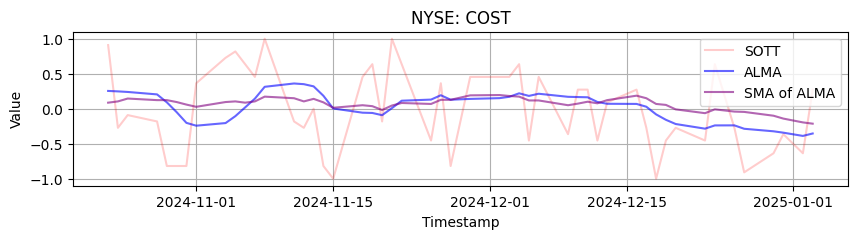

In [19]:
# Verify that we recreated the author's pine script correctly

data = df.tail(50)

plt.figure(figsize=(10, 2))
plt.plot(data['timestamp'], data['sott'], label='SOTT', color='red', alpha=0.2)
plt.plot(data['timestamp'], data['alma'], label='ALMA', color='blue', alpha=0.6)
plt.plot(data['timestamp'], data['sma'], label='SMA of ALMA', color='purple', alpha=0.6)
plt.title('NYSE: COST')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [20]:
# look for suggested entries

df['diff'] = df['alma'] - df['sma']
df['crossing'] = (df['diff'] * df['diff'].shift(1) < 0)

In [24]:
TP = 0.08  # Take profit: 0.8%
SL = 0.03  # Stop loss: 0.5%

# Initialize variables for logging results
profit_loss_log = []
trade_log = []
open_positions = []
total_trades = 0
winning_trades = 0
time_in_trades = []

# Open log file
with open("trade_log.txt", "w") as log_file:
    log_file.write("Trade Log\n")
    log_file.write("=" * 40 + "\n")

    # Iterate through data
    for i, row in df.iterrows():
        close_price = row["close"]
        current_date = row["timestamp"]  # Assuming a 'date' column in the DataFrame
        rsi = row["rsi"]
        crossing = row["crossing"]

        # Check open positions
        updated_positions = []
        for position in open_positions:
            if position["type"] == "LONG":
                tp_price = position["entry"] * (1 + TP)
                sl_price = position["entry"] * (1 - SL)
                if close_price >= tp_price or close_price <= sl_price:
                    # Calculate profit/loss
                    result = (
                        (tp_price - position["entry"]) / position["entry"] * 100
                        if close_price >= tp_price
                        else (sl_price - position["entry"]) / position["entry"] * 100
                    )
                    profit_loss_log.append(result)
                    trade_log.append(
                        f"Trade {total_trades + 1}: Entered LONG @ {position['entry']} on {position['entry_date']} "
                        f"and EXITED @ {close_price} on {current_date} for a profit/loss of {result:.2f}%\n"
                    )
                    log_file.write(trade_log[-1])
                    total_trades += 1
                    if result > 0:
                        winning_trades += 1
                else:
                    updated_positions.append(position)
            elif position["type"] == "SHORT":
                tp_price = position["entry"] * (1 - TP)
                sl_price = position["entry"] * (1 + SL)
                if close_price <= tp_price or close_price >= sl_price:
                    # Calculate profit/loss
                    result = (
                        (position["entry"] - tp_price) / position["entry"] * 100
                        if close_price <= tp_price
                        else (position["entry"] - sl_price) / position["entry"] * 100
                    )
                    profit_loss_log.append(result)
                    trade_log.append(
                        f"Trade {total_trades + 1}: Entered SHORT @ {position['entry']} on {position['entry_date']} "
                        f"and EXITED @ {close_price} on {current_date} for a profit/loss of {result:.2f}%\n"
                    )
                    log_file.write(trade_log[-1])
                    total_trades += 1
                    if result > 0:
                        winning_trades += 1
                else:
                    updated_positions.append(position)

        open_positions = updated_positions

        # Check for new trades
        if crossing and rsi < 50:
            open_positions.append(
                {"type": "LONG", "entry": close_price, "entry_date": current_date}
            )

    # Calculate and log statistics
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0

    log_file.write("\nSummary Statistics\n")
    log_file.write("=" * 40 + "\n")
    log_file.write(f"Total Trades: {total_trades}\n")
    log_file.write(f"Win Rate: {win_rate:.2f}%\n")
    log_file.write(f"Total Profit/Loss: {sum(profit_loss_log):.2f}%\n")

# Console outputs
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total Profit/Loss: {sum(profit_loss_log):.2f}%")
print(profit_loss_log)


Total Trades: 79
Win Rate: 49.37%
Total Profit/Loss: 192.00%
[-3.0000000000000004, -3.000000000000005, -2.9999999999999942, -3.0000000000000093, -2.9999999999999973, -3.0000000000000093, -3.0000000000000067, -3.000000000000007, -3.000000000000005, 7.999999999999997, -2.9999999999999964, -3.0000000000000018, -3.00000000000001, -3.0000000000000018, -2.9999999999999987, -3.0000000000000018, -3.000000000000004, -3.0000000000000058, 8.000000000000016, -3.0000000000000027, -2.999999999999999, -2.999999999999995, -2.9999999999999947, -2.999999999999996, -2.999999999999995, -2.9999999999999996, 8.00000000000001, 8.000000000000004, 7.999999999999999, 8.0, -2.999999999999995, -3.000000000000005, -3.0000000000000018, -2.9999999999999987, 8.000000000000004, 8.000000000000009, 8.000000000000005, 8.000000000000007, -2.9999999999999987, -3.000000000000009, 8.000000000000009, -3.0000000000000004, -3.0000000000000018, 8.000000000000009, 8.000000000000002, 7.999999999999997, -3.0000000000000044, 8.00000